# Push to the Github

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

In [73]:
# make sure update the token everytime you make changes
token = ""

In [79]:
# only run this to refresh the destination path
%cd ..
!rm -rf Santander-Customer-Transaction-Prediction

/content


In [78]:
# Clone your repository
!git clone https://{token}@github.com/buz321/Santander-Customer-Transaction-Prediction.git

# Move your notebook from Colab to the repository
!cp /content/drive/MyDrive/'Santander Customer Transaction Prediction'/'Santander Customer Transaction Prediction.ipynb' /content/Santander-Customer-Transaction-Prediction/

# Navigate to the repo directory
%cd /content/Santander-Customer-Transaction-Prediction/

# Configure GitHub credentials


# Add, commit, and push the notebook
!git add 'Santander Customer Transaction Prediction.ipynb'
!git commit -m "Add new Jupyter notebook from Google Colab"
!git push origin main  # Replace 'main' if your default branch is different


fatal: destination path 'Santander-Customer-Transaction-Prediction' already exists and is not an empty directory.
/content/Santander-Customer-Transaction-Prediction
On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	Santander-Customer-Transaction-Prediction/

nothing added to commit but untracked files present (use "git add" to track)
Everything up-to-date


# Version Control
| Version | Date       | Note                  |
|---------|------------|-----------------------|
| V0.1    | 01-07-2024 | Initial draft         |
| V0.2    | 09-07-2024 | Added more evaluation metrics     |
| V1.0    | 19-08-2024 | First Release     |
| V1.1    | TBD | Including logistic regression and logistic regressioncv to compare model performance - in progress  |


# Background
* This is part of Kaggle competition work.

* The data was obtained from this link: https://www.kaggle.com/competitions/santander-customer-transaction-prediction/overview

* Using an anonymized dataset containing numeric feature variables, the binary target column, and a string ID_code column, the value of target column in the test set will be predicted.

# 1.Google Drive Mount

In [4]:
# This step is only required if you are using google colab

from google.colab import drive

# Mount Google Drive (set the correct drive path)
drive.mount('/content/drive')


Mounted at /content/drive


# 2.Libraries

In [ ]:
pip install -U lightgbm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 27.0 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    roc_curve,
    auc
)

from lightgbm import LGBMClassifier, early_stopping
from scipy.stats import randint as sp_randint

import plotly.graph_objects as go

# Datasets for testing purposes
from sklearn.datasets import make_regression


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 3.Load the dataset

In [3]:
# Specify the path to the CSV files in Google Drive
train_path = '/content/drive/MyDrive/Santander Customer Transaction Prediction/train.csv'
test_path = '/content/drive/MyDrive/Santander Customer Transaction Prediction/test.csv'

# Read train.csv
train_df = pd.read_csv(train_path)

# Read test.csv
test_df = pd.read_csv(test_path)


# 4.Data Exploration

## 4.1 Train dataset

In [4]:
# Display the first few rows of the train DataFrame
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


The problem with `.dtypes` when there are too many variables is that you don't know how many different datatypes there are in your variables.



In [6]:
train_df.dtypes

,0
ID_code,object
target,int64
var_0,float64
var_1,float64
var_2,float64
...,...
var_195,float64
var_196,float64
var_197,float64
var_198,float64


In the code below, we have identified that we have only **int64** and **float64** datatypes.

In [7]:
train_df.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

The code below shows the number of variables for each datatypes.

In [8]:
# Initialize counters
sum_int = 0
sum_float = 0

# Iterate over the data types of the DataFrame
for column, dtype in train_df.dtypes.items():
    if dtype == 'int64':
        sum_int += 1
    elif dtype == 'float64':
        sum_float += 1

# Print the results
print(f'Number of int64 columns: {sum_int}')
print(f'Number of float64 columns: {sum_float}')

Number of int64 columns: 1
Number of float64 columns: 200


The code below checks the missing values in each variables.
(Used `.empty` for a series)

In [9]:
# Calculate the number of missing values in each column
missing_values = train_df.isna().sum()

# Identify columns with missing values
columns_with_na = missing_values[missing_values > 0]

if columns_with_na.empty == True:
    print('No missing values')
else:
    print(columns_with_na)

No missing values


In [10]:
# we can check the shape of the test dataset
print(train_df.shape)
print(f"Test dataset: \nThere are {train_df.shape[0]} rows, and {train_df.shape[1]} columns in this dataset")

(200000, 202)
Test dataset: 
There are 200000 rows, and 202 columns in this dataset


## 4.2 Correlation Check

* Note: since there are 200 variables in the dataset, it is hard to plot the correlation matrix.

In [ ]:
# Filter out paris of high correlation (e.g., threshold 0.5)
threshold = 0.5
high_corr_var = []
corr_matrix = train_df.corr().abs()

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_var.append((corr_matrix.columns[i], corr_matrix.columns[j]))

# Print out parits of high correlation
if high_corr_var:
    print("High Correlation Variables (Threshold > 0.8):")
    for var_pair in high_corr_var:
        print(var_pair)
else:
    print("No high correlation variables found.")

No high correlation variables found.


## 4.3 Test dataset

In [11]:
# Display the first few rows of the test DataFrame
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


The problem with `.dtypes` when there are too many variables is that you don't know how many different datatypes there are in your variables.

In [13]:
test_df.dtypes

,0
ID_code,object
var_0,float64
var_1,float64
var_2,float64
var_3,float64
...,...
var_195,float64
var_196,float64
var_197,float64
var_198,float64


In the code below, we have identified that we have only **int64** datatype.

In [14]:
test_df.dtypes.unique()

array([dtype('O'), dtype('float64')], dtype=object)

In [15]:
# Initialize counters
sum_float_test = 0

# Iterate over the data types of the DataFrame
for column, dtype in test_df.dtypes.items():
    if dtype == 'float64':
        sum_float_test += 1

# Print the results
print(f'Number of float64 columns: {sum_float_test}')

Number of float64 columns: 200


The code below checks the missing values in each variables.
(Used `.empty` for a series)

In [16]:
# Calculate the number of missing values in each column
missing_values_test = test_df.isna().sum()

# Identify columns with missing values
columns_with_na_test = missing_values_test[missing_values_test > 0]

if columns_with_na_test.empty == True:
    print('No missing values')
else:
    print(columns_with_na)

No missing values


In [17]:
# we can check the shape of the test dataset
print(test_df.shape)
print(f"Test dataset: \nThere are {test_df.shape[0]} rows, and {test_df.shape[1]} columns in this dataset")

(200000, 201)
Test dataset: 
There are 200000 rows, and 201 columns in this dataset


## 4.4 Target Variable

* Here, we identify **target** variable as a Target Variable as it is the outcome we want to look at.

As shown below, the target variable is <font color = 'red'>highly imbalanced</font>, which could potentially casue biase in the output model.


  - When the target variable in a dataset is highly imbalanced—meaning that one class or category is significantly more prevalent than others—it can indeed introduce bias into the output model. This bias occurs because many machine learning algorithms, especially those that optimize for overall accuracy, may become biased towards predicting the majority class more often, simply because it appears more frequently in the data.

1. <font color = 'pink'> Accuracy Paradox</font>:

    The model may achieve high accuracy by always predicting the majority class, but it fails to correctly predict the minority class.

2. <font color = 'pink'> Misclassification of Minority Class</font>:

    The model may not learn to recognize patterns in the minority class, leading to poor performance (e.g., low recall or precision) for that class.

3. <font color = 'pink'> Evaluation Metrics</font>:

    Accuracy can be misleading in imbalanced data; it doesn’t reflect the model's performance on the minority class.

In [18]:
train_df['target'].value_counts()

,count
target,
0,179902
1,20098


In [19]:
value_counts = train_df['target'].value_counts()

# Filter value that is not 0
value_counts = value_counts[value_counts > 0]

# Plotly bar graph
fig = go.Figure(data=[go.Bar(x=value_counts.index.astype(str), y=value_counts.values, marker_color='skyblue')])
fig.update_layout(
    title='Target Distribution',
    xaxis_title='Target',
    yaxis_title='Count',
    xaxis=dict(tickmode='auto')
)

fig.show()

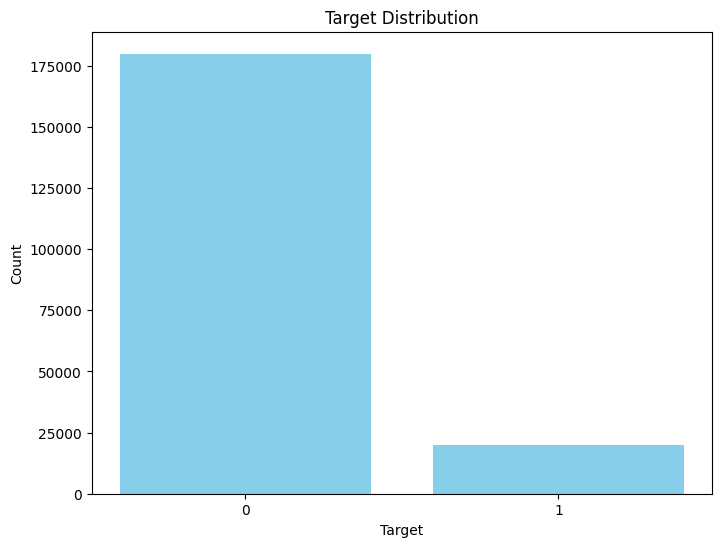

In [20]:
# Matplotlib bar plot
plt.figure(figsize=(8, 6))
plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Distribution')
plt.xticks(rotation=0)  # x axis rotation set to 0
plt.show()

# 5.Base Model Building

In [21]:
# make a list for variables to convert
cat_l_train = ['ID_code']
cat_l_test = ['ID_code']


# Use LabelEncoder to numerically encode categorical variables
label_encoder = LabelEncoder()

for column in cat_l_train:
    train_df[column] = label_encoder.fit_transform(train_df[column])

for column in cat_l_test:
    test_df[column] = label_encoder.fit_transform(test_df[column])

# Change specific variable into categorical variable using `astype()`
train_df[cat_l_train] = train_df[cat_l_train].astype('category')
test_df[cat_l_test] = test_df[cat_l_test].astype('category')

In [22]:
X = train_df.drop('target', axis = 1)
# Our target variable is 'Status'
y = train_df['target']
# Splitting the data -> Spljt ratio : 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
model = lgb.LGBMClassifier(learning_rate=0.02,max_depth=-5, n_estimators = 200, random_state=42)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)], eval_metric='logloss')

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

[LightGBM] [Info] Number of positive: 16001, number of negative: 143999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.817361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51003
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100006 -> initscore=-2.197155
[LightGBM] [Info] Start training from score -2.197155
Accuracy: 0.898025


In [24]:
# Predict probabilities on the test set
y_prob = model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
y_prob

array([0.03341486, 0.16130267, 0.05554431, ..., 0.13731208, 0.11924913,
       0.11823001])

# 6.Hyperparameter Tuning

In [ ]:
# Define your model
model = LGBMClassifier(verbosity=1)  # Set verbosity for debug output

# Define an expanded parameter grid
param_dist = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
    'max_depth': sp_randint(3, 8),
    'n_estimators': sp_randint(100, 301),
}

# Use RandomizedSearchCV with early stopping
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    scoring='neg_log_loss',
    cv=5,  # N-fold cross-validation
    n_iter=20,  # Number of random combinations to try
    random_state=42,
    verbose=1  # Set verbosity for more detailed output
)

# Fit the randomized search with early stopping
random_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # Validation set
    eval_metric='logloss',  # Metric to evaluate
    callbacks=[early_stopping(stopping_rounds=20)],  # Number of rounds with no improvement to stop training
)

# Print the best parameters found
print(f"Best Parameters: {random_search.best_params_}")


# 7.Applying the best parameters

* Train the model again with the best parameters gained above.

In [26]:
# Apply the best parameters from the cell above
model_best = lgb.LGBMClassifier(learning_rate=0.1,max_depth=7,n_estimators=260, random_state=42)
model_best.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)], eval_metric='logloss')

# Make predictions on the test set
y_pred_best = model_best.predict(X_test)

# Evaluate the model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Accuracy: {accuracy_best}")

[LightGBM] [Info] Number of positive: 16001, number of negative: 143999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.461497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51003
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100006 -> initscore=-2.197155
[LightGBM] [Info] Start training from score -2.197155
Accuracy: 0.91665


In [27]:
# Predict probabilities on the test set
y_prob_best = model_best.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
y_prob_best

array([0.00528255, 0.04083885, 0.0122165 , ..., 0.15946749, 0.22822091,
       0.04993415])

# 8.Evaluation

## 8.1 AUC - Base Model

* We will evaluate the base model by using **AUC**



In [29]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting with Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name=f'ROC curve (area = {roc_auc:.2f})',
    line=dict(color='red', width=2)
))

fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Random',
    line=dict(color='gray', width=2, dash='dash')
))

fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    showlegend=True,
    template='plotly_dark'
)

fig.show()

# Print the accuracy
y_pred_best = model_best.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Accuracy: {accuracy_best}")


Accuracy: 0.91665


## 8.2 AUC - Best Parameter Model

* We will evaluate the model with the best parameters by using **AUC**

In [30]:
# Calculate ROC curve and AUC
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
roc_auc_best = auc(fpr_best, tpr_best)

# Plotting with Plotly
fig = go.Figure()

# ROC curve for model_best
fig.add_trace(go.Scatter(
    x=fpr_best,
    y=tpr_best,
    mode='lines',
    name=f'Model Best ROC curve (area = {roc_auc_best:.2f})',
    line=dict(color='blue', width=2)
))

# Random classifier line
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Random',
    line=dict(color='gray', width=2, dash='dash')
))

# Update layout
fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    showlegend=True,
    template='plotly_dark'
)

fig.show()

# Print the accuracy
y_pred_best = model_best.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)

print(f"Model Best Accuracy: {accuracy_best}")




Model Best Accuracy: 0.91665


## 8.3 AUC - Base model VS Best Parameter Model

In [33]:
# Calculate ROC curve and AUC
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
roc_auc_best = auc(fpr_best, tpr_best)

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting with Plotly
fig = go.Figure()

# ROC curve for model_best
fig.add_trace(go.Scatter(
    x=fpr_best,
    y=tpr_best,
    mode='lines',
    name=f'Model Best ROC curve (area = {roc_auc_best:.2f})',
    line=dict(color='blue', width=2)
))

# ROC curve for model
fig.add_trace(go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name=f'Model ROC curve (area = {roc_auc:.2f})',
    line=dict(color='red', width=2)
))

# Random classifier line
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Random',
    line=dict(color='gray', width=2, dash='dash')
))

# Update layout
fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    showlegend=True,
    template='plotly_dark'
)

fig.show()

# Print the accuracy
y_pred_best = model_best.predict(X_test)
y_pred = model.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Best Accuracy: {accuracy_best}")
print(f"Model Accuracy: {accuracy}")


Model Best Accuracy: 0.91665
Model Accuracy: 0.898025


## 8.4 Other Evaulation Metrics

### 8.4.1 Gini Score


* Gini score can be calculated using AUC value.

---

$$ Gini=2×AUC−1 $$

---



In [35]:
gini = 2 * roc_auc - 1
gini_best = 2 * roc_auc_best - 1

print(f"Gini Score: {gini:.5f}")
print(f"Gini Score: {gini_best:.5f}")

Gini Score: 0.68276
Gini Score: 0.76201


### 8.4.2 Precision

* Precision can be calculated as below:
---
$$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$

---

In [38]:
# All Evaluation Metrics
gini_best = 2 * roc_auc_best - 1
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
logloss_best = log_loss(y_test, y_pred_best)

gini = 2 * roc_auc - 1
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_prob)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Log Loss: {logloss:.4f}")

Accuracy: 0.8980
Precision: 0.8750
Recall: 0.0051
F1 Score: 0.0102
Log Loss: 0.2713


### 8.4.3 Recall

* Recall can be calculated as below:
---

$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$

---

In [ ]:
recall = recall_score(y_test, y_pred)
recall_best = recall_score(y_test, y_pred_best)

print(f"Recall: {recall:.4f}")
print(f"Recall: {recall_best:.4f}")

### 8.4.4 F1 Score
* F1 Score can be calculated as below:

---
$$ \text{F1 Score} = 2 \ * \frac{\text{Precision} \ * \text{Recall}}{\text{Precision} + \text{Recall}} $$


---

In [ ]:
f1 = f1_score(y_test, y_pred)
f1_best = f1_score(y_test, y_pred_best)

print(f"F1 Score: {f1:.4f}")
print(f"F1 Score: {f1_best:.4f}")

### 8.4.5 Log Loss
* Log Loss can be calculated as below:

---
$$ \text{Log Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left[y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i)\right] $$

---

In [ ]:
logloss = log_loss(y_test, y_prob)
logloss_best = log_loss(y_test, y_pred_best)

print(f"Log Loss: {logloss:.4f}")
print(f"Log Loss: {logloss_best:.4f}")

### 8.4.6 Evaulation Metrics Comparison

In [41]:
# V0.2 Added more evaluation metrics to compare between different models(09/07/2024)
# Creating a DataFrame from scratch
comp_table = {
    'Base': [gini, accuracy, precision, recall, f1, logloss],
    'Base + Best param': [gini_best, accuracy_best, precision_best, recall_best, f1_best, logloss_best],
}

comp_table = pd.DataFrame(comp_table)

# Setting custom row labels (index)
comp_table.index = ['Gini Score', 'Accuracy', 'Precison', 'Recall', 'F1 Score', 'Log Loss']

# Display the DataFrame as a table
comp_table

,Base,Base + Best param
Gini Score,0.682759,0.762014
Accuracy,0.898025,0.916650
Precison,0.875000,0.815029
Recall,0.005126,0.240908
F1 Score,0.010192,0.371891
Log Loss,0.271339,3.004239
